In [11]:
import pandas as pd
import numpy as np
import json as js
import matplotlib.pyplot as plt
import seaborn as sns
from fitter import Fitter
from sklearn.preprocessing import minmax_scale
%matplotlib inline


## Part 1. Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute
time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


## Approach:
- Break into 15 minute cycles
- Plot heatmaps along various time dimensions.

## Data Prep + Initial Plot

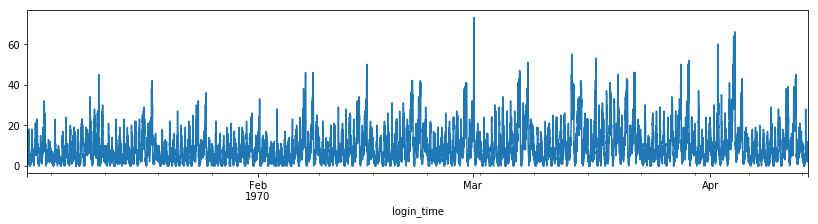

In [2]:
df_login = pd.read_json('./logins.json')
df_login['login_time'] = pd.to_datetime(df_login['login_time'])
df_login = df_login.set_index('login_time')
df_login['value'] = 1
df_login = df_login.resample('15MIN').count()
df_login['day'] = df_login.index.day
df_login['day_week'] = df_login.index.dayofweek
df_login['month'] = df_login.index.month
df_login['hour'] = df_login.index.hour
df_login['minute'] = df_login.index.minute

df_login['value'].plot(figsize = (14,3))

## Setting Plotting Function

In [209]:
class heat:
    def __init__(self, index_in, col_in, aggs_in):
        self.data = df_login.pivot_table(index = index_in, columns= col_in , values= 'value', aggfunc= aggs_in)
        self.title = "Heatmap (%ss): \n%s by %s" % (aggs_in.__name__, index_in, col_in)
    
    def query(self, query_in, **kwargs):
        self.data = self.data.query(query_in)
    
    def normalize(self,scale_axis = 0):
        self.data = self.data.fillna(0).apply(lambda x: minmax_scale(x), axis = scale_axis)
        self.title = self.title + "\n Scaled by axis: %s" % (scale_axis)
    
    def plot(self, size_in = (12,3)):
        fig, ax = plt.subplots(figsize = size_in)
        sns.heatmap(self.data,ax=ax)
        ax.set_title(self.title)
        plt.show()

## Plotting Day by Month:
- Missing data appears:
    - Missing data appears on the 13th through the 30th of April 1970
- Note that month 2 on 1970 only has 28 days that's why the below has "white" for missing on those days

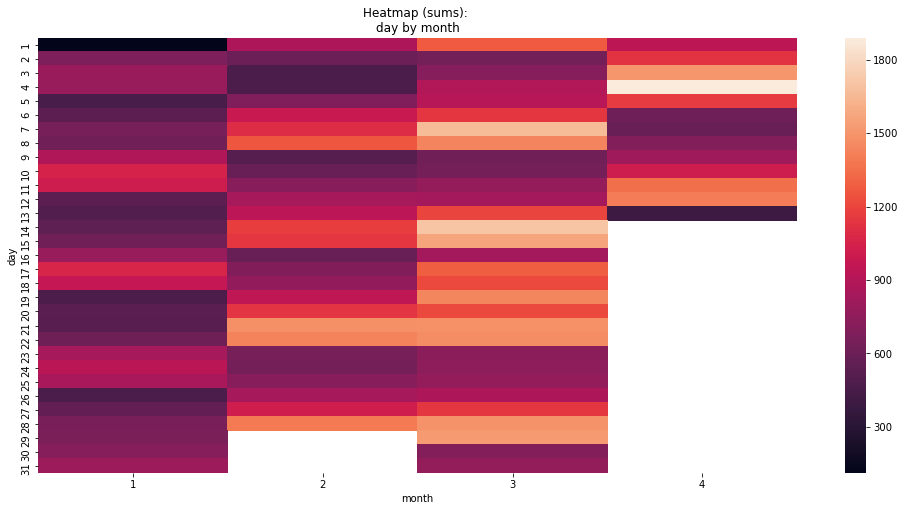

In [211]:
plot_dxm = heat('day','month',np.sum)
plot_dxm.plot((17,8))

## Missing data by Month-Day and Hour-Minute

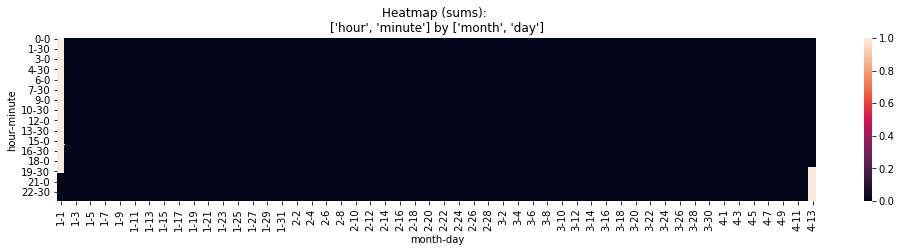

In [333]:
plot_dxm = heat(['hour','minute'],['month','day'],np.sum)
plot_dxm.data = plot_dxm.data.isnull()
plot_dxm.plot((17,3))

## Missing data by Month-Day and Hour-Minute: Deeper Dive

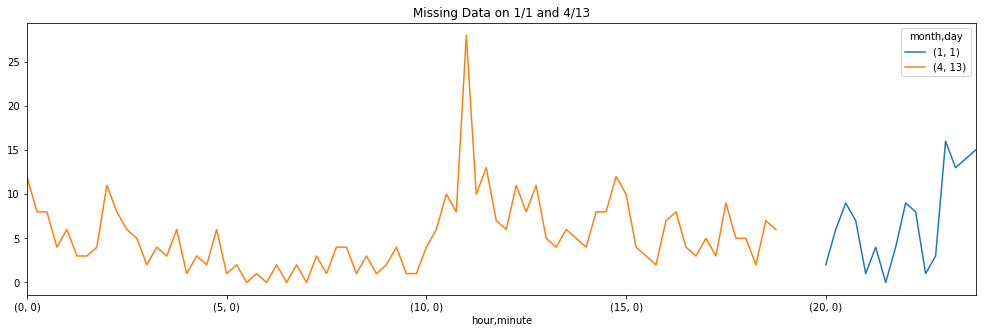

In [334]:
plot_dxm = heat(['month','day'],['hour','minute'],np.sum)
plot_dxm.query("(month == 1 & day == 1) | (month == 4 & day == 13)")
_ = plot_dxm.data.T.plot(figsize = (17,5), title= "Missing Data on 1/1 and 4/13")

### Explore Utilization: Day of Week by Hour-Minute (1)

Overall (Unscaled data):
- The single most active time in a week is sunday 4-5 am
- There is notable activity during lunch during the weekdays

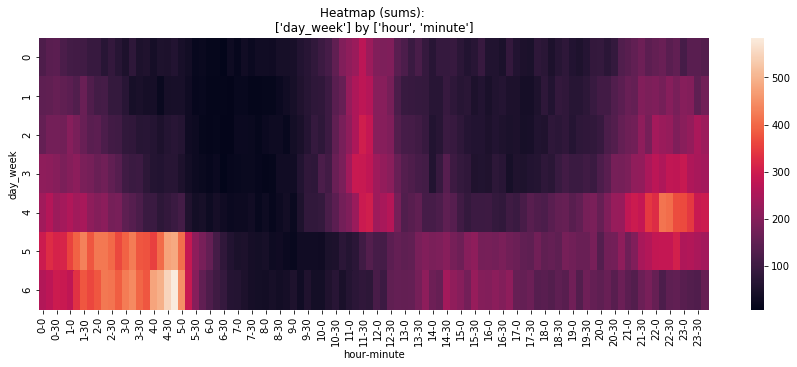

In [360]:
plot_dxm = heat(['day_week'],['hour','minute'],np.sum)
plot_dxm.plot((15,5))

### Explore Utilization: Day of Week by Hour-Minute (2)


Comparing Activity across each day of the week's hours (scaling by hours):
- People are more active during the hours of 8 am - 3 or 4 ish
- Mondays: Early Activity on Mondays
- Thursday / Friday / Saturday: Highest nighttime activity on Friday nights, with higher thatn usual activity on Thursday and Saturday nights
- Weekends: lower activity during time period of 9 - noon (brunch time?)
- Sunday nights: Lower activity on Sunday nights (People are getting a good nights rest?

C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


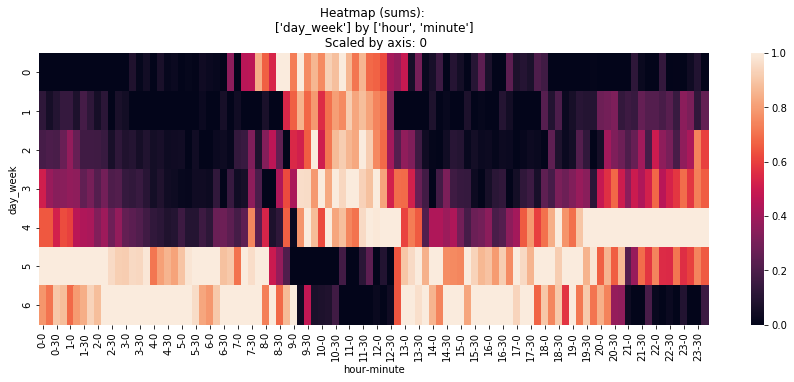

In [362]:
plot_dxm = heat(['day_week'],['hour','minute'],np.sum)
plot_dxm.normalize(0)
plot_dxm.plot((15,5))

### Explore Utilization: Day of Week by Hour-Minute (3)


Comparing each day's activity (scaling within each day):

- Most active time during weekdays
    - Mon - Thursday: Around 11:30 / Noon
    - Thursday / Friday: Late evening (10 and later)
- Most active time during weekends: 
    - Early morning (4 am - 5 am ish), these cities may have a very late last call.
    - Notable very early morning activity: from midnight to 3AM


C:\Users\Cglan\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


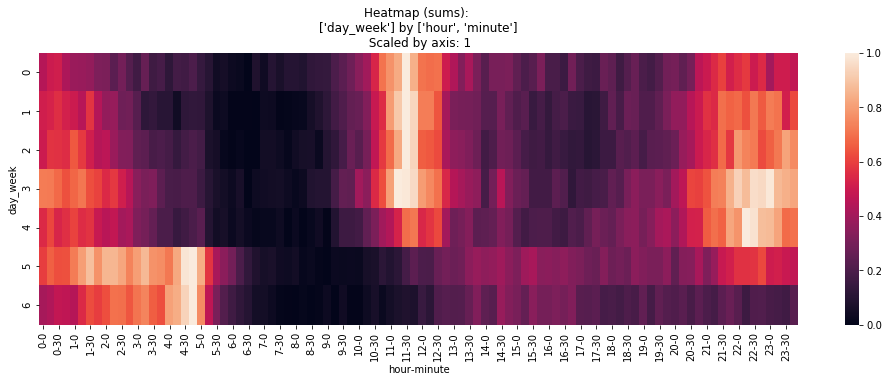

In [350]:
plot_dxm = heat(['day_week'],['hour','minute'],np.sum)
plot_dxm.normalize(1)
plot_dxm.plot((17,5))

## Month-Day by Hour-Minute Activity
- The single most active time / day was on March 1st at around 4:30 am

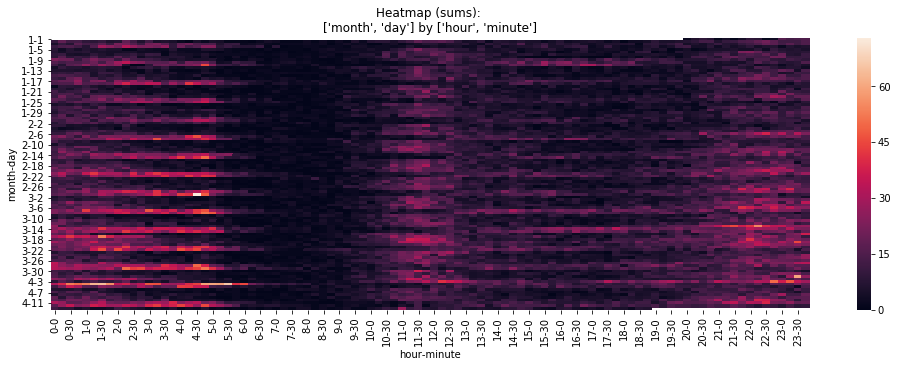

In [387]:
plot_dxm = heat(['month','day'],['hour','minute'],np.sum)
plot_dxm.plot((17,5)) 

### Does our data fit a theoretical distribution?
- use fitter to identify likely
- beta prime seems best!

In [571]:
import warnings 
warnings.filterwarnings('ignore')

fit = Fitter(df_login.value, distributions = ['gamma', 'rayleigh','betaprime','powerlognorm','genexpon'])
fit.fit()
params = fit.fitted_param['betaprime']

print('\n\nDistribution Parameters: \nalpha: %f \nbeta: %f \nloc: %f \nscale: %f  ' % fit.fitted_param['betaprime'])

Fitted gamma distribution with error=0.022634981578095306)
Fitted rayleigh distribution with error=0.03039988857680295)
Fitted betaprime distribution with error=0.021859096024646738)
Fitted powerlognorm distribution with error=0.021946924858014225)
Fitted genexpon distribution with error=0.02202853145042371)


Distribution Parameters: 
alpha: 1.292149 
beta: 1947.931143 
loc: -0.152594 
scale: 14266.759319  


sumsquare_error
betaprime            0.021859
powerlognorm         0.021947
genexpon             0.022029
gamma                0.022635
rayleigh             0.030400

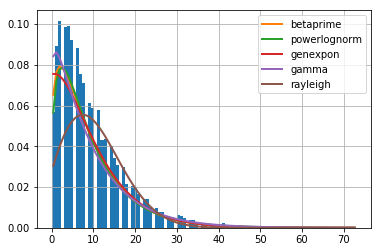

In [564]:
fit.summary()

In [567]:
def get_prob(x):
    return betaprime.cdf( x = x, a =params[0] , b = params[1], loc = params[2], scale = params[3])
["Probability Less than or equal to %i: %i Percent" % (i, np.round(get_prob(i),3)*100) for i in [5,10,20,30]]

['Probability Less than or equal to 5: 37 Percent',
 'Probability Less than or equal to 10: 64 Percent',
 'Probability Less than or equal to 20: 89 Percent',
 'Probability Less than or equal to 30: 97 Percent']

## Data Dictionary

    ● city: city this user signed up in
    ● phone: primary device for this user
    ● signup_date: date of account registration; in the form ‘YYYY MM DD’
    ● last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
    ● avg_dist: the average distance in miles per trip taken in the first 30 days after signup
    ● avg_rating_by_driver: the rider’s average rating over all of their trips
    ● avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
    ● surge_pct: the percent of trips taken with surge multiplier > 1
    ● avg_surge: The average surge multiplier over all of this user’s trips
    ● trips_in_first_30_days: the number of trips this user took in the first 30 days after
    signing up
    ● ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
    FALSE otherwise
    ● weekday_pct: the percent of the user’s trips occurring during a weekday

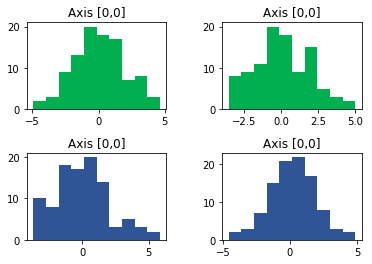

In [78]:
from scipy import stats
rvs1 = stats.norm.rvs(0,2, 100)
rvs2 = stats.norm.rvs(0,2, 100)
rvs3 = stats.norm.rvs(0,2, 100)
rvs4 = stats.norm.rvs(0,2, 100)


f, ax = plt.subplots(2, 2, sharey=False)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.4, hspace=.5)
ax[0, 1].hist(x = pd.Series(rvs1),color =  '#00b050')
ax[0, 1].set_title('Axis [0,0]')

ax[1, 0].hist(x = pd.Series(rvs2),color =  '#2F5597')
ax[1, 0].set_title('Axis [0,0]')

ax[0, 0].hist(x = pd.Series(rvs3),color =  '#00b050')
ax[0, 0].set_title('Axis [0,0]')

ax[1, 1].hist(x = pd.Series(rvs4),color =  '#2F5597')
ax[1, 1].set_title('Axis [0,0]')

plt.show()


## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way
toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.


### **Question 1.** What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The metric I would chose would be a p-value (to measure whether or not there is a detectable difference) and Cohen's D (To identify the effect size) in an experiment measuring "out-of-city" rides rate. This measure is defined as 

\begin{equation*}
 \text{1.}\frac{\text{(Out-of-City Rides)}}{\text{(Out-of-City Rides) + (Within-City Rides)}} = \text{Daily Out-of-City Activity Rate}.
\end{equation*}

For each driver, we would then create a median value during a defined time period and compare the differences of the median. So that for driver i we have:


hold this  part below
\begin{equation*}
 \text{Median Daily OOC Rate (Pre) - Median Daily OOC Rate (Post) = Difference in Median Daily OOC Rate} 
\end{equation*}


The goal would be to look at pre-toll subsidy and post-toll subsidy rates and see whether or not there is a statistical detectable difference overall.
    
### **Question 2.** Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on ... 

#### ... how you will implement the experiment?

The goal of this experiment is to set up conditions where we can measure the above  median "daily out-of-city rate" during pre-subsidy time frame and post-subsidy timeframe.

**A. Define geographic propensity: **
    - Because of the differences of each city, it is likely that there may be a self-selection bias with drivers. It could be that drivers who prefer a certain driving preferences will tend to be in Gotham or Metropolis (for example, factors like proximity to home, level of congestion, and types of routes that customers prefer). 
    - This means define what a "metropolis" driver is and what a "gotham" driver is. This can be achieved by looking at the proportion of driving within each geography. For example implementing a rule such as: "If a driver has more than 90% of its drives within a Metropolis, they are classified as a "Metropolis driver".
    
    
**B. Define analysis time frame: **
    - It's important to choose a time frame that will least likely skew the results. For example: holiday seasons, or big events. A week Beyonce performances in Metropolis will likely cause a surge in requests of rides over the Metropolis from Gotham. These types of events may introduce extraneous variables (undersirable factors that influence our experiment). 
    - Therefore, it is important to choose a long enough timeline that will give us the most comporable conditions (1 month for example) and also choose a cost-effective time period as the longer the study period we set the more costly this experiment will be. 
    - This time period will be of equal lengths during the "pre-subsidy" and "post-subsidy" period. 
    - The end result will allow us to compute "Average Daily Out-of-City Rides Activity Rate" for one month before and after subsidy. 
   


#### ... what statistical test(s) you will conduct to verify the significance of your results?

observation:
- Randomization Test on Matched Samples
    - Does subsidy impact the driver's Median OOC Activity Rate
- Choose permutation of 10,000 or more.
- Sample 1000 at a time 10,000 times to create approxmiate distributions
- Compute Mean of (Before - After)
- Pool all data points together. Randomly assign Before and After for each person. Compute Mean Before-After) Do this 10,000 times. 
- Compute the p value of the above distribution of Mean Differences in relationship to true Mean of Differences before. 

why?
The advantages of permutation tests are

•  the lack of assumptions about the distribution of the underlying data,

•  their flexibility in the kinds of data they can handle (nominal, ordinal, interval/ratio),

•  and their being relatively straightforward to conduct and interpret.



c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

- I would caveat by saying that certain data points have been omitted
- A more robust study would require looking at driver characterisics and look at more complex classification models providing us a probability that each individual would drive OOC. 
- Execute the above tests for both Gotham and Metropolis. 
- If the results support, I would go ahead and frame this conversation in terms of chance, "if there were no effect, what's the chance that we're actually getting a result such as the one we do just by sheer luck?"

## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

pbalh lsahfd ls